# Project 1: Digit Classification with KNN and Naive Bayes

In this project, you'll implement your own image recognition system for classifying digits. Read through the code and the instructions carefully and add your own code where indicated. Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but <b> please prepare your own write-up (with your own code). </b>

If you're interested, check out these links related to digit recognition:

* Yann Lecun's MNIST benchmarks: http://yann.lecun.com/exdb/mnist/
* Stanford Streetview research and data: http://ufldl.stanford.edu/housenumbers/

Finally, if you'd like to get started with Tensorflow, you can read through this tutorial: https://www.tensorflow.org/tutorials/keras/basic_classification. It uses a dataset called "fashion_mnist", which is identical in structure to the original digit mnist, but uses images of clothing rather than images of digits. The number of training examples and number of labels is the same. In fact, you can simply replace the code that loads "fashion_mnist" with "mnist" and everything should work fine.

In [2]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# Import a bunch of libraries.
import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

# Set the randomizer seed so results are the same each time.
np.random.seed(0)
print("DONE")

DONE


In [3]:
import sklearn
sklearn.__version__
print("DONE")

DONE


Load the data. Notice that the data gets partitioned into training, development, and test sets. Also, a small subset of the training data called mini_train_data and mini_train_labels gets defined, which you should use in all the experiments below, unless otherwise noted.

In [4]:
# Load the digit data from https://www.openml.org/d/554 or from default local location '~/scikit_learn_data/...'
X, Y = fetch_openml(name='mnist_784', return_X_y=True, cache=False)


# Rescale grayscale values to [0,1].
X = X / 255.0

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(X.shape[0]))
X, Y = X[shuffle], Y[shuffle]

print('data shape: ', X.shape)
print('label shape:', Y.shape)

# Set some variables to hold test, dev, and training data.
test_data, test_labels = X[61000:], Y[61000:]
dev_data, dev_labels = X[60000:61000], Y[60000:61000]
train_data, train_labels = X[:60000], Y[:60000]
mini_train_data, mini_train_labels = X[:1000], Y[:1000]
print("DONE")

data shape:  (70000, 784)
label shape: (70000,)
DONE


In [5]:
def confusion_matrix_plot(conf_matrix):
    """ Confusion matrix matplotlib plot
    # param conf_matrix: nested list of TP, TN, FP, FN
    # return: None
    """
    fig, ax = plt.subplots(figsize=(15, 15))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center')

    plt.xlabel('Predicted label')
    plt.ylabel('True label')

    plt.tight_layout()
    plt.show()

### Part 1:

Show a 10x10 grid that visualizes 10 examples of each digit.

Notes:
* You can use `plt.rc()` for setting the colormap, for example to black and white.
* You can use `plt.subplot()` for creating subplots.
* You can use `plt.imshow()` for rendering a matrix.
* You can use `np.array.reshape()` for reshaping a 1D feature vector into a 2D matrix (for rendering).

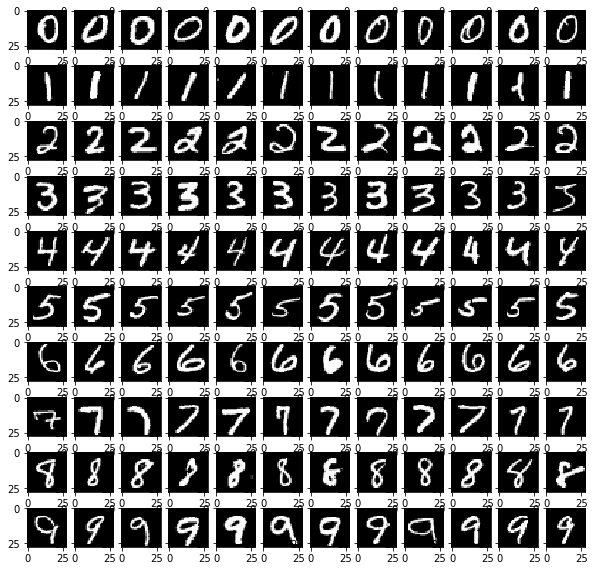

In [6]:
def P1(num_examples=10):
    """P1 cycles through the mini training dataset, collecting examples of each digit and storing
    the corresponding image data in a 4D numpy array"""

    count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     #Counts how many examples have been collected of each digit
    data = np.zeros((10,num_examples,28,28))   #Stores user defined number of examples of each digit
    i = 0
    
    #Loop through mini_train_labels until there are num_examples of each digit
    while sum(count) < num_examples*10:
        ilabel = int(mini_train_labels[i])
        idata = np.reshape(mini_train_data[i], (28,28))
        if count[ilabel] < num_examples:
            data[ilabel, count[ilabel],:,:] = idata
            count[ilabel] = count[ilabel] + 1
        i = i + 1
    
    #Define figure and axes. Loop through all images in data, displaying them in subplots.
    i = 0
    j = 0
    fig, axes = plt.subplots(10,num_examples, figsize=(10,10))
    for i in range(0,10):
        for j in range(0,num_examples):
            axes[i,j].imshow(data[i,j,:,:], cmap='gray')
    plt.show()


P1(12)

### Part 2:

Produce k-Nearest Neighbors models with k $\in$ [1,3,5,7,9].  Evaluate and show the accuracy of each model. For the 1-Nearest Neighbor model, additionally show the precision, recall, and F1 for each label. Which digit is the most difficult for the 1-Nearest Neighbor model to recognize?

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `classification_report` to get precision, recall, and F1 results.

In [7]:
def P2(k_values):

    for i in k_values:
        #Define and fit a KNN model for mini_train_data for the specified n
        knn = KNeighborsClassifier(n_neighbors=i, p=2, metric='minkowski')
        knn.fit(mini_train_data, mini_train_labels)
        print("K Nearest Neighbors model generated with n=", i)
        
        #Test the KNN model on test_sample number of test data. Display predicted and actual values.
        test_sample = 99
        ktest = test_data[0:test_sample]
        prediction = knn.predict(ktest)
        print("Prediction of", test_sample+1 , " test examples.")
        print("Predicted class labels for each test example: ")
        print(prediction)
        print("Actual class labels for each test example: ")
        print(test_labels[0:test_sample])
        
        #Display Accuracy
        errors = 0
        for j in range(0,test_sample):
            if prediction[j] != test_labels[j]:
                errors = errors + 1
        print("Misclassifications:", errors, "out of", test_sample+1)
        print("Error Rate:", errors/test_sample)
        print()
        
        #Display Precision, Recall, and F1 for each label
        print(classification_report(test_labels[0:test_sample],prediction, labels=[0,1,2,3,4,5,6,7,8,9]))
        
k_values = [1, 3, 5, 7, 9]
P2(k_values)

K Nearest Neighbors model generated with n= 1
Prediction of 100  test examples.
Predicted class labels for each test example: 
['6' '1' '8' '5' '3' '8' '8' '4' '6' '6' '9' '5' '8' '5' '7' '8' '7' '8'
 '8' '9' '6' '3' '2' '0' '9' '7' '4' '2' '1' '1' '4' '4' '4' '7' '8' '2'
 '6' '9' '0' '9' '4' '6' '0' '0' '7' '9' '0' '8' '0' '5' '7' '1' '2' '7'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '9' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '7' '2' '7' '1' '7' '9' '1' '5' '9' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Actual class labels for each test example: 
['6' '1' '3' '3' '5' '8' '8' '4' '6' '6' '9' '5' '8' '5' '2' '8' '7' '3'
 '8' '9' '6' '3' '2' '9' '9' '7' '4' '2' '1' '1' '4' '4' '4' '7' '8' '2'
 '6' '9' '0' '9' '4' '6' '0' '0' '7' '8' '0' '8' '0' '5' '7' '1' '2' '9'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '4' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '9' '2' '7' '1' '7' '9' '1' '5' '9' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Misclassifications: 10 

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n= 3
Prediction of 100  test examples.
Predicted class labels for each test example: 
['6' '1' '8' '3' '5' '8' '8' '4' '6' '6' '9' '5' '8' '5' '7' '8' '7' '3'
 '8' '4' '6' '3' '2' '0' '9' '7' '4' '7' '1' '1' '4' '4' '4' '7' '1' '2'
 '6' '4' '0' '9' '4' '6' '0' '0' '7' '9' '0' '8' '0' '4' '7' '1' '2' '4'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '9' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '4' '2' '7' '1' '7' '4' '1' '5' '9' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Actual class labels for each test example: 
['6' '1' '3' '3' '5' '8' '8' '4' '6' '6' '9' '5' '8' '5' '2' '8' '7' '3'
 '8' '9' '6' '3' '2' '9' '9' '7' '4' '2' '1' '1' '4' '4' '4' '7' '8' '2'
 '6' '9' '0' '9' '4' '6' '0' '0' '7' '8' '0' '8' '0' '5' '7' '1' '2' '9'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '4' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '9' '2' '7' '1' '7' '9' '1' '5' '9' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Misclassifications: 13 

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n= 5
Prediction of 100  test examples.
Predicted class labels for each test example: 
['6' '1' '3' '3' '5' '8' '8' '4' '6' '6' '9' '5' '8' '5' '2' '8' '7' '3'
 '8' '9' '6' '3' '2' '0' '9' '7' '4' '7' '1' '1' '4' '9' '4' '7' '1' '2'
 '6' '4' '0' '4' '4' '6' '0' '0' '7' '8' '0' '8' '0' '9' '7' '1' '2' '4'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '9' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '7' '2' '7' '1' '7' '7' '1' '5' '9' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Actual class labels for each test example: 
['6' '1' '3' '3' '5' '8' '8' '4' '6' '6' '9' '5' '8' '5' '2' '8' '7' '3'
 '8' '9' '6' '3' '2' '9' '9' '7' '4' '2' '1' '1' '4' '4' '4' '7' '8' '2'
 '6' '9' '0' '9' '4' '6' '0' '0' '7' '8' '0' '8' '0' '5' '7' '1' '2' '9'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '4' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '9' '2' '7' '1' '7' '9' '1' '5' '9' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Misclassifications: 11 

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n= 7
Prediction of 100  test examples.
Predicted class labels for each test example: 
['6' '1' '3' '3' '5' '8' '8' '4' '6' '6' '9' '5' '1' '5' '2' '8' '7' '8'
 '8' '9' '6' '3' '2' '0' '9' '7' '4' '7' '1' '1' '4' '9' '4' '7' '8' '2'
 '6' '4' '0' '9' '4' '6' '0' '0' '7' '8' '0' '8' '0' '9' '7' '1' '2' '4'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '9' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '7' '2' '7' '1' '7' '9' '1' '5' '7' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Actual class labels for each test example: 
['6' '1' '3' '3' '5' '8' '8' '4' '6' '6' '9' '5' '8' '5' '2' '8' '7' '3'
 '8' '9' '6' '3' '2' '9' '9' '7' '4' '2' '1' '1' '4' '4' '4' '7' '8' '2'
 '6' '9' '0' '9' '4' '6' '0' '0' '7' '8' '0' '8' '0' '5' '7' '1' '2' '9'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '4' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '9' '2' '7' '1' '7' '9' '1' '5' '9' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Misclassifications: 11 

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n= 9
Prediction of 100  test examples.
Predicted class labels for each test example: 
['6' '1' '3' '3' '5' '8' '8' '4' '6' '6' '9' '5' '1' '5' '1' '8' '7' '8'
 '8' '9' '6' '3' '2' '0' '9' '7' '4' '7' '1' '1' '4' '4' '4' '7' '1' '2'
 '6' '9' '0' '4' '4' '6' '0' '0' '7' '8' '0' '8' '0' '9' '7' '1' '2' '4'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '9' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '7' '2' '7' '1' '7' '9' '1' '5' '7' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Actual class labels for each test example: 
['6' '1' '3' '3' '5' '8' '8' '4' '6' '6' '9' '5' '8' '5' '2' '8' '7' '3'
 '8' '9' '6' '3' '2' '9' '9' '7' '4' '2' '1' '1' '4' '4' '4' '7' '8' '2'
 '6' '9' '0' '9' '4' '6' '0' '0' '7' '8' '0' '8' '0' '5' '7' '1' '2' '9'
 '5' '1' '6' '0' '7' '6' '7' '1' '4' '2' '5' '6' '0' '4' '2' '8' '6' '7'
 '5' '0' '7' '4' '1' '3' '9' '2' '7' '1' '7' '9' '1' '5' '9' '0' '2' '9'
 '8' '3' '9' '0' '5' '5' '2' '3' '3']
Misclassifications: 12 

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


ANSWER: The n=1 model has the most difficulty recognizing "7"

### Part 3:

Produce 1-Nearest Neighbor models using training data of various sizes.  Evaluate and show the performance of each model.  Additionally, show the time needed to measure the performance of each model.

Notes:
* Train on subsets of the train set.  For each subset, take just the first part of the train set without re-ordering.
* Evaluate on the dev set.
* You can use `KNeighborsClassifier` to produce a k-nearest neighbor model.
* You can use `time.time()` to measure elapsed time of operations.

In [8]:
def P3(train_sizes, accuracies):
    """Iterate through a number of training data sizes and produce a KNN model with n=1
    for each training size. Evaluate and show each model's error, precision recall, F1,
    and runtime."""
    
    for i in train_sizes:
        #Generate a KNN model for using a subset of the training data with size = train_sizes
        knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
        knn.fit(train_data[0:i], train_labels[0:i])
        print("K Nearest Neighbors model generated with n=1 and training data size of",i,".")
        
        #Start clock before evaluating model performance
        t1 = time.time()

        #Test the model with 100 test data
        test_sample = 100
        ktest = dev_data[0:test_sample]
        prediction = knn.predict(ktest)
        print("Prediction of ",test_sample," test examples.")
        print("Predicted class labels for each test example: ")
        print(prediction)
        print("Actual class labels for each test example: ")
        print(dev_labels[0:test_sample])
        
        #Stop Clock after evaluating model performance
        t2 = time.time()

        print("Time Elapsed:", (t2-t1), "seconds")
        print()

        #Display Accuracy
        errors = 0
        for j in range(0,test_sample):
            if prediction[j] != dev_labels[j]:
                errors = errors + 1
        print("Misclassifications:", errors, "out of", test_sample)
        print("Error Rate:", errors/test_sample)
        print()
        accuracies.append(1-errors/test_sample)
        
        #Display Precision, Recall, and F1 for each label
        print(classification_report(test_labels[0:test_sample],prediction, labels=[0,1,2,3,4,5,6,7,8,9]))

train_sizes = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 25600]
accuracies = []
P3(train_sizes, accuracies)
print(accuracies)

K Nearest Neighbors model generated with n=1 and training data size of 100 .
Prediction of  100  test examples.
Predicted class labels for each test example: 
['2' '4' '1' '9' '6' '0' '3' '7' '7' '0' '5' '3' '1' '1' '3' '7' '1' '1'
 '4' '1' '2' '1' '4' '1' '7' '9' '4' '2' '1' '5' '3' '2' '4' '8' '1' '4'
 '1' '7' '9' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '3' '1' '4'
 '2' '7' '1' '7' '4' '1' '7' '4' '5' '5' '0' '7' '1' '9' '8' '3' '9' '4'
 '6' '0' '6' '1' '3' '1' '9' '1' '0' '8' '6' '3' '1' '8' '5' '2' '1' '5'
 '6' '1' '1' '0' '4' '4' '4' '4' '8' '1']
Actual class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '8' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '3' 

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)
C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n=1 and training data size of 800 .
Prediction of  100  test examples.
Predicted class labels for each test example: 
['8' '4' '1' '9' '6' '6' '3' '7' '8' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '9' '9' '2' '1' '5' '3' '8' '8' '8' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '7' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '1' '7' '9' '8' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '5' '0'
 '6' '0' '6' '1' '5' '1' '9' '1' '0' '8' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '8' '4' '7' '4' '6' '8' '1']
Actual class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '8' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '3' 

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n=1 and training data size of 1600 .
Prediction of  100  test examples.
Predicted class labels for each test example: 
['8' '4' '1' '9' '6' '6' '3' '7' '1' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '9' '9' '2' '1' '5' '3' '2' '8' '8' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '7' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '1' '7' '9' '8' '7' '4' '0' '5' '0' '7' '1' '9' '8' '3' '9' '0'
 '6' '0' '6' '1' '5' '1' '9' '1' '0' '8' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '5' '4' '7' '4' '6' '8' '1']
Actual class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '8' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '3'

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n=1 and training data size of 3200 .
Prediction of  100  test examples.
Predicted class labels for each test example: 
['8' '4' '1' '9' '6' '6' '3' '7' '1' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '8' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '1' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '5' '9' '0'
 '6' '0' '6' '1' '5' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '5' '4' '7' '4' '6' '8' '1']
Actual class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '8' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '3'

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n=1 and training data size of 6400 .
Prediction of  100  test examples.
Predicted class labels for each test example: 
['8' '4' '1' '9' '6' '6' '3' '7' '9' '0' '5' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '1' '7' '9' '6' '7' '4' '0' '5' '0' '2' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '3' '4' '7' '4' '6' '8' '1']
Actual class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '8' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '3'

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n=1 and training data size of 12800 .
Prediction of  100  test examples.
Predicted class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '9' '0' '5' '3' '1' '1' '3' '7' '1' '1'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '4' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '5' '2' '1' '5'
 '6' '1' '9' '0' '4' '7' '4' '6' '8' '1']
Actual class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '8' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '3

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


K Nearest Neighbors model generated with n=1 and training data size of 25600 .
Prediction of  100  test examples.
Predicted class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '1' '0' '8' '3' '1' '1' '3' '7' '1' '1'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '4' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '7' '4' '6' '8' '1']
Actual class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '8' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '3

C:\Users\John\anaconda3\lib\site-packages\numpy\lib\arraysetops.py:565: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


### Part 4:

Produce a linear regression model that predicts accuracy of a 1-Nearest Neighbor model given training set size. Show $R^2$ of the linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data.  What's wrong with using linear regression here?

Apply a transformation to the predictor features and a transformation to the outcome that make the predictions more reasonable.  Show $R^2$ of the improved linear regression model.  Show the accuracies predicted for training set sizes 60000, 120000, and 1000000.  Show a lineplot of actual accuracies and predicted accuracies vs. training set size over the range of training set sizes in the training data - be sure to display accuracies and training set sizes in appropriate units.

Notes:
* Train the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* Evaluate the linear regression models on all of the (transformed) accuracies estimated in Problem 3.
* You can use `LinearRegression` to produce a linear regression model.
* Remember that the sklearn `fit()` functions take an input matrix X and output vector Y. So, each input example in X is a vector, even if it contains only a single value.
* Hint re: predictor feature transform: Accuracy increases with training set size logarithmically.
* Hint re: outcome transform: When y is a number in range 0 to 1, then odds(y)=y/(1-y) is a number in range 0 to infinity.

K Nearest Neighbors model generated with n=1 and training data size of 100 .
Prediction of  1000  test examples.
Predicted class labels for each test example: 
['2' '4' '1' '9' '6' '0' '3' '7' '7' '0' '5' '3' '1' '1' '3' '7' '1' '1'
 '4' '1' '2' '1' '4' '1' '7' '9' '4' '2' '1' '5' '3' '2' '4' '8' '1' '4'
 '1' '7' '9' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '3' '1' '4'
 '2' '7' '1' '7' '4' '1' '7' '4' '5' '5' '0' '7' '1' '9' '8' '3' '9' '4'
 '6' '0' '6' '1' '3' '1' '9' '1' '0' '8' '6' '3' '1' '8' '5' '2' '1' '5'
 '6' '1' '1' '0' '4' '4' '4' '4' '8' '1' '1' '5' '7' '4' '4' '4' '2' '7'
 '0' '5' '2' '3' '4' '6' '4' '0' '5' '7' '8' '4' '2' '0' '9' '6' '7' '1'
 '0' '5' '0' '7' '1' '0' '0' '0' '7' '1' '0' '5' '4' '6' '1' '6' '7' '8'
 '3' '0' '7' '4' '1' '7' '2' '5' '4' '2' '7' '5' '8' '5' '1' '0' '1' '0'
 '9' '4' '4' '5' '1' '1' '1' '9' '5' '2' '1' '7' '8' '1' '2' '8' '5' '0'
 '6' '4' '8' '7' '3' '9' '8' '5' '3' '0' '1' '4' '8' '8' '3' '4' '8' '3'
 '7' '4' '2' '1' '0' '4' '1' '3' '4' 

K Nearest Neighbors model generated with n=1 and training data size of 500 .
Prediction of  1000  test examples.
Predicted class labels for each test example: 
['8' '4' '1' '9' '6' '6' '3' '7' '7' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '9' '9' '2' '1' '5' '3' '8' '4' '1' '1' '4'
 '1' '7' '9' '7' '4' '5' '6' '7' '7' '5' '7' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '1' '7' '9' '8' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '7' '0'
 '6' '0' '6' '1' '5' '1' '9' '1' '0' '8' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '8' '4' '7' '4' '6' '8' '1' '1' '5' '9' '4' '9' '9' '2' '3'
 '0' '5' '2' '8' '8' '6' '9' '0' '8' '7' '5' '3' '2' '0' '9' '6' '7' '1'
 '0' '5' '0' '4' '1' '5' '0' '0' '7' '1' '0' '5' '6' '6' '4' '6' '7' '8'
 '3' '0' '5' '6' '1' '7' '2' '5' '6' '2' '7' '5' '2' '5' '1' '0' '1' '3'
 '9' '4' '9' '5' '1' '1' '1' '9' '5' '2' '1' '7' '8' '1' '2' '8' '5' '0'
 '6' '9' '8' '7' '3' '9' '8' '5' '2' '0' '8' '7' '8' '8' '3' '4' '3' '3'
 '7' '9' '2' '1' '2' '9' '7' '3' '4' 

Prediction of  1000  test examples.
Predicted class labels for each test example: 
['8' '4' '1' '9' '6' '6' '3' '2' '1' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '9' '9' '2' '1' '5' '3' '2' '8' '8' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '7' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '1' '7' '9' '8' '7' '4' '0' '5' '0' '7' '1' '9' '8' '3' '5' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '8' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '8' '4' '7' '4' '6' '8' '1' '1' '5' '9' '4' '9' '9' '2' '3'
 '0' '5' '2' '8' '5' '6' '9' '0' '5' '7' '5' '3' '2' '0' '4' '6' '7' '1'
 '0' '5' '0' '4' '1' '5' '0' '0' '7' '1' '0' '5' '6' '6' '4' '6' '7' '8'
 '3' '0' '3' '6' '1' '7' '8' '6' '6' '2' '7' '5' '2' '5' '1' '0' '1' '8'
 '2' '4' '9' '5' '1' '1' '1' '9' '5' '2' '1' '7' '8' '1' '2' '8' '5' '0'
 '6' '9' '6' '7' '8' '9' '8' '5' '9' '0' '5' '9' '8' '8' '3' '4' '8' '3'
 '7' '9' '2' '1' '2' '9' '7' '3' '4' '2' '6' '0' '9' '4' '7' '1' '9' '6'
 '7' '4' '7' '1' '0' '8' '0' '5' '5' '7' 

K Nearest Neighbors model generated with n=1 and training data size of 5000 .
Prediction of  1000  test examples.
Predicted class labels for each test example: 
['8' '4' '1' '9' '6' '6' '3' '7' '8' '0' '5' '3' '1' '1' '3' '7' '1' '9'
 '9' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '1' '7' '4' '6' '7' '4' '0' '5' '0' '2' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '5' '4' '7' '4' '6' '8' '1' '1' '5' '9' '4' '9' '9' '2' '3'
 '0' '5' '2' '8' '8' '6' '9' '0' '5' '0' '5' '3' '2' '0' '4' '0' '7' '1'
 '0' '5' '0' '4' '1' '5' '0' '0' '7' '1' '0' '5' '6' '6' '7' '6' '9' '8'
 '3' '0' '3' '6' '1' '7' '8' '6' '6' '2' '7' '5' '2' '5' '1' '0' '1' '0'
 '2' '4' '4' '5' '1' '1' '1' '9' '5' '2' '1' '7' '8' '1' '2' '8' '5' '0'
 '6' '9' '6' '7' '3' '9' '8' '5' '6' '0' '5' '9' '8' '8' '3' '4' '8' '3'
 '7' '9' '2' '1' '2' '9' '2' '3' '4'

K Nearest Neighbors model generated with n=1 and training data size of 10000 .
Prediction of  1000  test examples.
Predicted class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '9' '0' '5' '3' '1' '1' '3' '7' '1' '1'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '1' '7' '4' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '5' '2' '1' '5'
 '6' '1' '9' '3' '4' '7' '4' '6' '8' '1' '1' '5' '9' '4' '9' '9' '2' '3'
 '0' '5' '2' '8' '8' '6' '9' '0' '5' '0' '8' '3' '2' '0' '4' '0' '7' '1'
 '0' '5' '0' '4' '1' '5' '0' '0' '7' '1' '0' '5' '6' '6' '2' '6' '7' '8'
 '3' '0' '3' '6' '1' '7' '2' '6' '6' '2' '7' '5' '2' '5' '1' '0' '8' '0'
 '2' '4' '4' '5' '1' '1' '1' '9' '5' '2' '1' '7' '8' '1' '2' '8' '5' '0'
 '6' '9' '1' '7' '3' '9' '8' '5' '2' '0' '5' '9' '8' '8' '3' '4' '8' '3'
 '7' '9' '2' '1' '2' '9' '2' '6' '4

K Nearest Neighbors model generated with n=1 and training data size of 20000 .
Prediction of  1000  test examples.
Predicted class labels for each test example: 
['8' '4' '1' '9' '6' '6' '3' '7' '1' '0' '8' '3' '1' '1' '3' '7' '1' '1'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '4' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '5' '2' '1' '5'
 '6' '1' '9' '0' '4' '7' '4' '6' '8' '1' '1' '5' '9' '4' '9' '9' '2' '3'
 '0' '5' '2' '9' '8' '6' '9' '0' '5' '0' '8' '3' '2' '0' '4' '0' '7' '1'
 '0' '5' '0' '4' '1' '5' '0' '0' '7' '1' '0' '5' '6' '6' '2' '5' '7' '8'
 '3' '0' '3' '6' '1' '7' '2' '6' '6' '2' '7' '5' '2' '5' '1' '0' '8' '5'
 '2' '4' '4' '5' '1' '1' '1' '9' '5' '2' '1' '7' '8' '1' '2' '8' '5' '0'
 '6' '9' '1' '7' '3' '9' '8' '5' '8' '0' '5' '9' '8' '8' '3' '4' '8' '3'
 '7' '9' '2' '1' '2' '9' '2' '5' '4

K Nearest Neighbors model generated with n=1 and training data size of 30000 .
Prediction of  1000  test examples.
Predicted class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '1' '0' '8' '3' '1' '1' '3' '7' '1' '1'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '7' '4' '6' '8' '1' '1' '5' '9' '4' '9' '9' '2' '3'
 '0' '5' '2' '8' '8' '6' '9' '0' '5' '0' '8' '3' '2' '0' '4' '0' '7' '1'
 '0' '5' '0' '4' '1' '5' '0' '0' '7' '1' '0' '5' '6' '6' '2' '5' '7' '8'
 '3' '0' '3' '6' '1' '7' '2' '6' '6' '2' '7' '5' '2' '5' '1' '0' '8' '5'
 '2' '4' '4' '5' '1' '1' '1' '9' '5' '2' '1' '7' '8' '1' '2' '8' '5' '0'
 '6' '9' '1' '7' '3' '9' '8' '5' '8' '0' '5' '9' '8' '8' '3' '4' '8' '3'
 '7' '9' '2' '1' '2' '9' '2' '3' '4

K Nearest Neighbors model generated with n=1 and training data size of 40000 .
Prediction of  1000  test examples.
Predicted class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '1' '0' '8' '3' '1' '1' '3' '7' '1' '1'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '7' '4' '6' '8' '1' '1' '5' '9' '4' '9' '9' '2' '3'
 '0' '5' '2' '8' '8' '6' '9' '0' '5' '0' '8' '3' '2' '0' '4' '0' '7' '1'
 '0' '5' '0' '4' '1' '5' '0' '0' '7' '1' '0' '5' '6' '6' '2' '5' '7' '8'
 '3' '0' '3' '6' '1' '7' '8' '5' '6' '2' '7' '5' '2' '5' '1' '0' '8' '5'
 '2' '4' '4' '5' '1' '1' '1' '9' '5' '2' '1' '3' '8' '1' '2' '8' '5' '0'
 '6' '9' '1' '7' '3' '9' '8' '5' '8' '0' '5' '9' '8' '8' '3' '4' '8' '3'
 '7' '9' '2' '1' '2' '9' '2' '3' '4

K Nearest Neighbors model generated with n=1 and training data size of 50000 .
Prediction of  1000  test examples.
Predicted class labels for each test example: 
['8' '9' '1' '9' '6' '6' '3' '7' '1' '0' '8' '3' '1' '1' '3' '7' '1' '9'
 '4' '2' '2' '8' '9' '1' '7' '4' '9' '2' '1' '5' '3' '2' '8' '2' '1' '4'
 '1' '7' '4' '7' '4' '5' '6' '7' '7' '5' '4' '3' '1' '7' '6' '8' '1' '6'
 '2' '7' '8' '7' '9' '6' '7' '4' '0' '5' '0' '7' '1' '9' '8' '8' '9' '0'
 '6' '0' '6' '1' '8' '1' '9' '1' '0' '2' '6' '3' '1' '8' '3' '2' '1' '5'
 '6' '1' '9' '0' '4' '7' '4' '6' '8' '1' '1' '5' '9' '4' '9' '9' '2' '3'
 '0' '5' '2' '8' '8' '6' '9' '0' '5' '0' '8' '3' '2' '0' '4' '0' '7' '1'
 '0' '5' '0' '4' '1' '5' '0' '0' '7' '1' '0' '5' '6' '6' '2' '5' '7' '8'
 '3' '0' '3' '6' '1' '7' '8' '5' '6' '2' '7' '5' '2' '5' '1' '0' '8' '3'
 '2' '4' '4' '5' '1' '1' '1' '9' '5' '2' '1' '3' '8' '1' '2' '8' '5' '0'
 '6' '9' '1' '7' '3' '9' '8' '5' '8' '0' '5' '9' '8' '8' '3' '4' '8' '3'
 '7' '9' '2' '1' '2' '9' '2' '3' '4

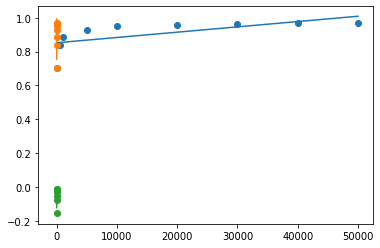

In [43]:
def P4():
    
    accuracy = []
    sizes = [100, 500, 1000, 5000, 10000, 20000, 30000, 40000, 50000]
    
    for i in sizes:
        
        #Generate a KNN model for using a subset of the training data with size = train_sizes
        knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
        knn.fit(train_data[0:i], train_labels[0:i])
        print("K Nearest Neighbors model generated with n=1 and training data size of",i,".")
        
        #Test the model with 1000 test data
        test_sample = 1000
        ktest = dev_data[0:test_sample]
        prediction = knn.predict(ktest)
        print("Prediction of ",test_sample," test examples.")
        print("Predicted class labels for each test example: ")
        print(prediction)
        print("Actual class labels for each test example: ")
        print(dev_labels[0:test_sample])
        
        #Display Accuracy
        errors = 0
        for j in range(0,test_sample):
            if prediction[j] != dev_labels[j]:
                errors = errors + 1
        print("Misclassifications:", errors, "out of", test_sample)
        print("Error Rate:", errors/test_sample)
        print()
        accuracy.append(1-errors/test_sample)
        
    accuracy = np.array(accuracy).reshape(-1,1)
    sizes = np.array(sizes).reshape(-1,1)

    #Model 1
    lr1 = LinearRegression()
    lr1.fit(sizes,accuracy)
    print(lr1.predict(np.array([60000,120000,1000000]).reshape(-1,1)))
    print(lr1.score(sizes,accuracy))
    plt.scatter(sizes,accuracy)
    plt.plot(sizes,lr1.predict(sizes))
    
    #Model 2
    log_sizes = np.log10(sizes)
    pred = np.array([60000,120000,1000000]).reshape(-1,1)
    lr2 = LinearRegression()
    lr2.fit(log_sizes,accuracy)
    print(lr2.predict(np.log10(pred)))
    print(lr2.score(log_sizes,accuracy))
    plt.scatter(log_sizes,accuracy)
    plt.plot(log_sizes,lr2.predict(log_sizes))
    
    #Model 3
    log_accuracy = np.log10(accuracy)
    lr3 = LinearRegression()
    lr3.fit(log_sizes,log_accuracy)
    print(np.power(10,lr3.predict(np.log10(pred))))
    print(lr3.score(log_sizes,log_accuracy))
    plt.scatter(log_sizes,log_accuracy)
    plt.plot(log_sizes,lr3.predict(log_sizes))
    
    #Model 4

P4()

ANSWER:

### Part 5:

Produce a 1-Nearest Neighbor model and show the confusion matrix. Which pair of digits does the model confuse most often? Show the images of these most often confused digits.

Notes:
- Train on the mini train set.
- Evaluate performance on the dev set.
- You can use `confusion_matrix()` to produce a confusion matrix.

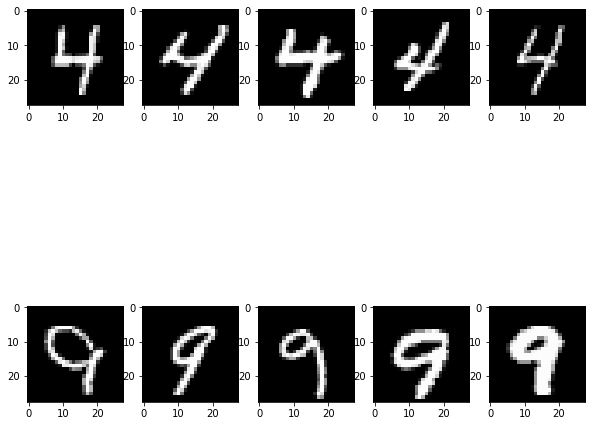

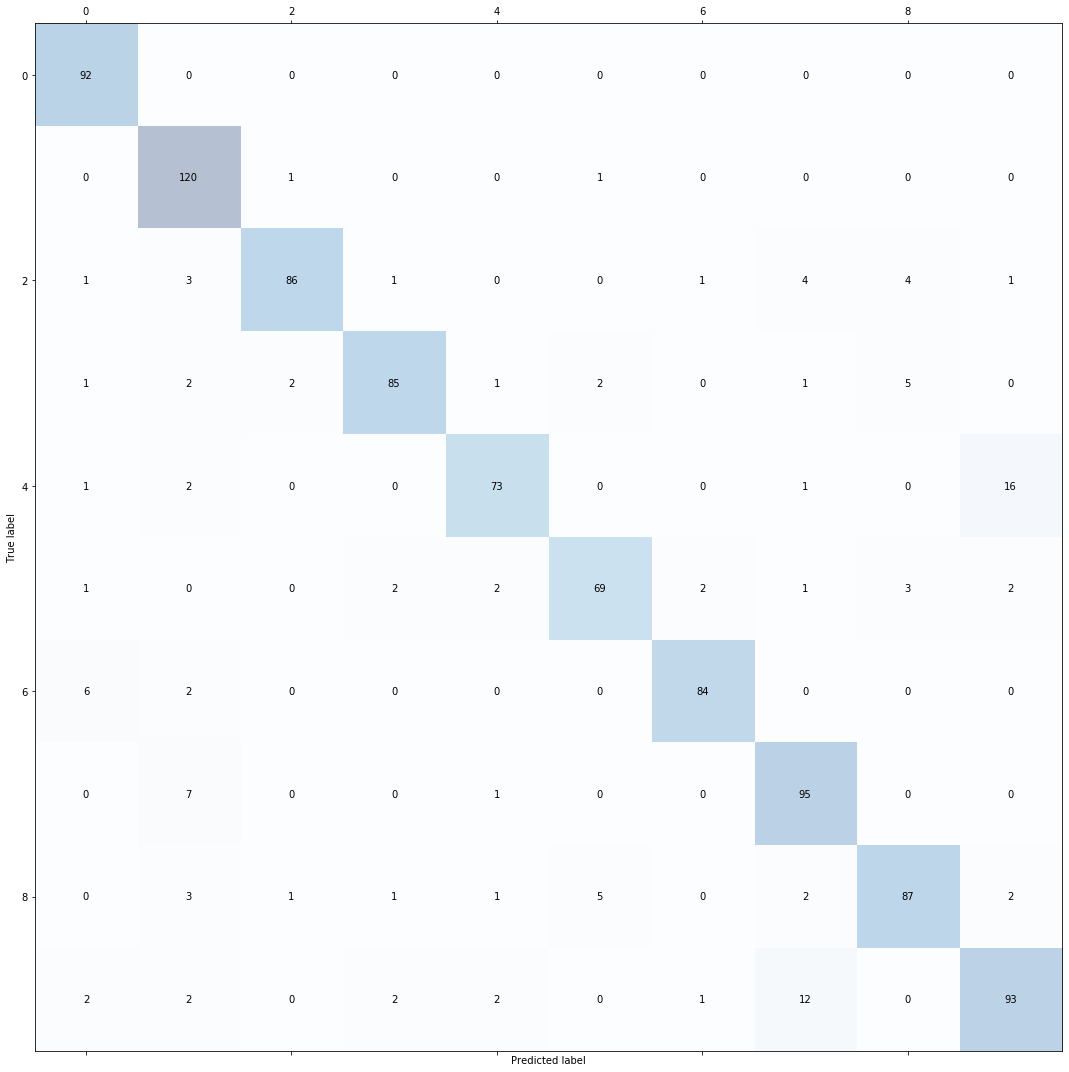

In [19]:
def P5():
    """Produce a KNN (n=1) from mini_train_data and test on 1000 test_data. 
    Plot the confusion matrix of the results"""
    knn = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
    knn.fit(mini_train_data, mini_train_labels)
    ktest = test_data[0:1000]
    klab = test_labels[0:1000]
    prediction = knn.predict(ktest)

    mat = confusion_matrix(klab,prediction)
    confusion_matrix_plot(mat)

def four_nine(num_examples=10):
    """four_nine cycles through the mini training dataset, collecting examples of each digit and storing
    the corresponding image data in a 4D numpy array. In this case, P1 has been modified to only display
    4's and 9's"""

    count = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]     #Counts how many examples have been collected of each digit
    data = np.zeros((10,num_examples,28,28))   #Stores user defined number of examples of each digit
    i = 0
    
    #Loop through mini_train_labels until there are num_examples of each digit
    while sum(count) < num_examples*10:
        ilabel = int(mini_train_labels[i])
        idata = np.reshape(mini_train_data[i], (28,28))
        if count[ilabel] < num_examples:
            data[ilabel, count[ilabel],:,:] = idata
            count[ilabel] = count[ilabel] + 1
        i = i + 1
    
    #Define figure and axes. Loop through examples of 4's and 9's
    i = 0
    j = 0
    fig, axes = plt.subplots(2,num_examples, figsize=(10,10))
    for i in range(0,num_examples):
            axes[0,i].imshow(data[4,i,:,:], cmap='gray')
            axes[1,i].imshow(data[9,i,:,:], cmap='gray')
    plt.show()

four_nine(5)
P5()


ANSWER: The model most often confuses "9" and "4"

### Part 6:

A common image processing technique is to smooth an image by blurring. The idea is that the value of a particular pixel is estimated as the weighted combination of the original value and the values around it. Typically, the blurring is Gaussian, i.e., the weight of a pixel's influence is determined by a Gaussian function over the distance to the relevant pixel.

Implement a simplified Gaussian blur filter by just using the 8 neighboring pixels like this: the smoothed value of a pixel is a weighted combination of the original value and the 8 neighboring values.

Pick a weight, then produce and evaluate four 1-Nearest Neighbor models by applying your blur filter in these ways:
- Do not use the filter
- Filter the training data but not the dev data
- Filter the dev data but not the training data
- Filter both training data and dev data

Show the accuracies of the four models evaluated as described.  Try to pick a weight that makes one model's accuracy at least 0.9.

Notes:
* Train on the (filtered) mini train set.
* Evaluate performance on the (filtered) dev set.
* There are other Guassian blur filters available, for example in `scipy.ndimage.filters`. You are welcome to experiment with those, but you are likely to get the best results with the simplified version described above.

In [0]:
#def P6():
    
### STUDENT START ###


### STUDENT END ###

#P6()

### Part 7:

Produce two Naive Bayes models and evaluate their performances.  Recall that Naive Bayes estimates P(feature|label), where each label is a categorical, not a real number.

For the first model, map pixel values to either 0 or 1, representing white or black - you should pre-process the data or use `BernoulliNB`'s `binarize` parameter to set the white/black separation threshold to 0.1.  Use `BernoulliNB` to produce the model.

For the second model, map pixel values to either 0, 1, or 2, representing white, gray, or black - you should pre-process the data, seting the white/gray/black separation thresholds to 0.1 and 0.9.  Use `MultinomialNB` to produce the model. 

Show the Bernoulli model accuracy and the Multinomial model accuracy.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* `sklearn`'s Naive Bayes methods can handle real numbers, but for this exercise explicitly do the mapping to categoricals. 

Does the multinomial version improve the results? Why or why not?

In [0]:
#def P7():

### STUDENT START ###


    
### STUDENT END ###

#P7()

ANSWER:

### Part 8:

Search across several values of the LaPlace smoothing parameter (alpha) to find its effect on a Bernoulli Naive Bayes model's performance.  Show the accuracy at each alpha value.

Notes:
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate performance by 5-fold cross-validation. 
* Use `GridSearchCV(..., ..., cv=..., scoring='accuracy', iid=False)` to vary alpha and evaluate performance by cross-validation.
* Cross-validation is based on partitions of the training data, so results will be a bit different than if you had used the dev set to evaluate performance.

What is the best value for alpha? What is the accuracy when alpha is near 0? Is this what you'd expect?

In [0]:
#def P8(alphas):

### STUDENT START ###



### STUDENT END ###

# alphas = {'alpha': [1.0e-10, 0.0001, 0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 10.0]}
# nb = P8(alphas)
# print()
# print("Best alpha = ", nb.best_params_)

ANSWER:

### Part 9:

Produce a model using Guassian Naive Bayes, which is intended for real-valued features, and evaluate performance. You will notice that it does not work so well. Diagnose the problem and apply a simple fix so that the model accuracy is around the same as for a Bernoulli Naive Bayes model. Show the model accuracy before your fix and the model accuracy after your fix.  Explain your solution.

Notes:
* Train on the mini train set.
* Evaluate performance on the dev set.
* Consider the effects of theta and sigma.  These are stored in the model's `theta_` and `sigma_` attributes.

In [0]:
#def P9():

### STUDENT END ###


### STUDENT END ###

#P9()

ANSWER:

### Part 10:

Because Naive Bayes produces a generative model, you can use it to generate digit images.

Produce a Bernoulli Naive Bayes model and then use it to generate a 10x20 grid with 20 example images of each digit. Each pixel output should be either 0 or 1, based on comparing some randomly generated number to the estimated probability of the pixel being either 0 or 1.  Show the grid.

Notes:
* You can use np.random.rand() to generate random numbers from a uniform distribution.
* The estimated probability of each pixel being 0 or 1 is stored in the model's `feature_log_prob_` attribute. You can use `np.exp()` to convert a log probability back to a probability.

How do the generated digit images compare to the training digit images?

In [0]:
#def P10(num_examples):

### STUDENT START ###


### STUDENT END ###

#P10(20)

ANSWER:

### Part 11:

Recall that a strongly calibrated classifier is rougly 90% accurate when the posterior probability of the predicted class is 0.9. A weakly calibrated classifier is more accurate when the posterior probability of the predicted class is 90% than when it is 80%. A poorly calibrated classifier has no positive correlation between posterior probability and accuracy.  

Produce a Bernoulli Naive Bayes model.  Evaluate performance: partition the dev set into several buckets based on the posterior probabilities of the predicted classes - think of a bin in a histogram- and then estimate the accuracy for each bucket. So, for each prediction, find the bucket to which the maximum posterior probability belongs, and update "correct" and "total" counters accordingly.  Show the accuracy for each bucket.

Notes:
* Set LaPlace smoothing (alpha) to the optimal value (from part 8).
* Set binarization threshold to 0.
* Train on the mini train set.
* Evaluate perfromance on the dev set.

How would you characterize the calibration for this Bernoulli Naive Bayes model?

In [0]:
#def P11(buckets, correct, total):
    
### STUDENT START ###


                
### STUDENT END ###

# buckets = [0.5, 0.9, 0.999, 0.99999, 0.9999999, 0.999999999, 0.99999999999, 0.9999999999999, 1.0]
# correct = [0 for i in buckets]
# total = [0 for i in buckets]

# P11(buckets, correct, total)

# for i in range(len(buckets)):
#     accuracy = 0.0
#     if (total[i] > 0): accuracy = correct[i] / total[i]
#     print('p(pred) is %.13f to %.13f    total = %3d    accuracy = %.3f' % (0 if i==0 else buckets[i-1], buckets[i], total[i], accuracy))

ANSWER:

### Part 12 EXTRA CREDIT:

Design new features to see if you can produce a Bernoulli Naive Bayes model with better performance.  Show the accuracy of a model based on the original features and the accuracy of the model based on the new features.

Here are a few ideas to get you started:
- Try summing or averaging the pixel values in each row.
- Try summing or averaging the pixel values in each column.
- Try summing or averaging the pixel values in each square block. (pick various block sizes)
- Try counting the number of enclosed regions. (8 usually has 2 enclosed regions, 9 usually has 1, and 7 usually has 0)

Notes:
* Train on the mini train set (enhanced to comprise the new features).
* Evaulate performance on the dev set.
* Ensure that your code is well commented.

In [0]:
#def P12():

### STUDENT START ###


### STUDENT END ###

#P12()